In [118]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping
import seaborn as sns
from IPython.core.display_functions import display
from IPython.display import Audio
from livelossplot import PlotLossesKeras

import keras
from keras import layers
from keras.models import Sequential

from keras_preprocessing.image import img_to_array

import tensorflow as tf
from keras.layers import *

import os
from tqdm.notebook import tqdm
from pathlib import Path
import shutil


from music_plots import *
import numpy as np

In [2]:
files = os.listdir('data/spectrograms')
tracks_df = load("data/tracks.csv")
genres_df = load("data/genres.csv")

In [3]:
track_ids = []
print(files)
for file in tqdm(files):
    pre, ext = os.path.splitext(file)
    track_ids.append(int(pre))

['73309.png', '32433.png', '127062.png', '131166.png', '14386.png', '66076.png', '30230.png', '67368.png', '143296.png', '73335.png', '122654.png', '122132.png', '71244.png', '43590.png', '126354.png', '25601.png', '71250.png', '124231.png', '38888.png', '132453.png', '126426.png', '75750.png', '55480.png', '117610.png', '129926.png', '112768.png', '115761.png', '12046.png', '129098.png', '12052.png', '113304.png', '115775.png', '99707.png', '133942.png', '58173.png', '19891.png', '75787.png', '80518.png', '45122.png', '118279.png', '134793.png', '51157.png', '10679.png', '116240.png', '42659.png', '81612.png', '62589.png', '96408.png', '116526.png', '122683.png', '28480.png', '21895.png', '30740.png', '109189.png', '118084.png', '13199.png', '127274.png', '108297.png', '72215.png', '132679.png', '70402.png', '93941.png', '76073.png', '133567.png', '17499.png', '144937.png', '123760.png', '133573.png', '137715.png', '43962.png', '11942.png', '122456.png', '65755.png', '141873.png', '73

  0%|          | 0/7847 [00:00<?, ?it/s]

In [4]:
#tracks_df.columns = pd.MultiIndex.from_product([['track'],['id']])
filtered_tracks = tracks_df.xs('track', level=0, axis=1)['genre_top'].loc[track_ids]
filtered_tracks

track_id
73309             Rock
32433       Electronic
127062            Folk
131166            Rock
14386          Hip-Hop
              ...     
139537    Instrumental
83791             Rock
122671    Instrumental
67365              Pop
71507       Electronic
Name: genre_top, Length: 7847, dtype: category
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

Some tracks don't have a genre

In [5]:
filtered_tracks.isna().any()

False

Check all top level genres

In [6]:
filtered_tracks.unique()

['Rock', 'Electronic', 'Folk', 'Hip-Hop', 'Pop', 'Instrumental', 'Experimental', 'International']
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

In [56]:
genres = {}
tmp_x = 0
#Assign value for the genres
#for i in genres_df[genres_df['parent']==0]['title'].unique():
for i in filtered_tracks.unique():
    genres[i] = tmp_x
    tmp_x = tmp_x + 1

print(genres)
genres_df[genres_df['parent']==0]

{'Rock': 0, 'Electronic': 1, 'Folk': 2, 'Hip-Hop': 3, 'Pop': 4, 'Instrumental': 5, 'Experimental': 6, 'International': 7}


,#tracks,parent,title,top_level
genre_id,,,,
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5
8,868,0,Old-Time / Historic,8
9,1987,0,Country,9
10,13845,0,Pop,10
12,32923,0,Rock,12
13,730,0,Easy Listening,13


Generate directories

In [42]:
Path("dataset").mkdir(parents=True, exist_ok=True)

for genre in tqdm(genres.keys()):
    Path("dataset/"+genre).mkdir(parents=True, exist_ok=True)

for track_id in tqdm(filtered_tracks.index):
    shutil.copyfile('data/spectrograms/' + str(track_id) + ".png", "dataset/" + filtered_tracks.loc[track_id] + "/" + str(track_id) + ".png")

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/7847 [00:00<?, ?it/s]

In [58]:
#Split dataset into chunks
train_ds = filtered_tracks.sample(frac = 0.8)

tmp_ds = filtered_tracks.drop(train_ds.index)
validation_ds = tmp_ds.sample(frac = 0.5)
test_ds = tmp_ds.drop(validation_ds.index)

print(f"Training has {len(train_ds)}, Validation has {len(validation_ds)}, Testing has {len(test_ds)}")

Training has 6278, Validation has 784, Testing has 785


In [59]:
training_data = []
training_labels = []
testing_data = []
testing_labels = []
validation_data = []
validation_labels = []

for i in tqdm(train_ds.index):
    image = tf.keras.preprocessing.image.load_img("data/spectrograms/" + str(i) + ".png")
    image = img_to_array(image)
    training_data.append(image)

    training_labels.append(genres[train_ds.loc[i]])

for i in tqdm(validation_ds.index):
    image = tf.keras.preprocessing.image.load_img("data/spectrograms/" + str(i) + ".png")
    image = img_to_array(image)
    validation_data.append(image)

    validation_labels.append(genres[validation_ds.loc[i]])

for i in tqdm(test_ds.index):
    image = tf.keras.preprocessing.image.load_img("data/spectrograms/" + str(i) + ".png")
    image = img_to_array(image)
    testing_data.append(image)

    testing_labels.append(genres[test_ds.loc[i]])


  0%|          | 0/6278 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/785 [00:00<?, ?it/s]

In [60]:
# Change all values between 0 and 1
training_data = np.array(training_data, dtype="float") / 255.0
training_labels = np.array(training_labels)

validation_data =  np.array(validation_data, dtype="float") / 255.0
validation_labels = np.array(validation_labels)

testing_data = np.array(testing_data, dtype="float") / 255.0
testing_labels = np.array(testing_labels)
print(f"Training has shape {training_data.shape}, Validation has shape {validation_data.shape}, Testing has shape {testing_data.shape}")

Training has shape (6278, 174, 484, 3), Validation has shape (784, 174, 484, 3), Testing has shape (785, 174, 484, 3)


In [43]:
img_shape = (484, 174)

In [111]:
def model(width, height, depth, classes):
    model = Sequential()

    model.add(Conv2D(25, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu', input_shape=(height, width, depth)))
    model.add(MaxPool2D(pool_size=(1,1)))

    model.add(Flatten())
    model.add(Dense(100, activation='relu'))

    model.add(Dense(classes, activation='softmax'))
    return model

In [120]:
def model2(width, height, depth, classes):
    return keras.Sequential([
        keras.Input(shape=(height, width, depth)),
        layers.Resizing(128, 128),

        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(5, 5), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(5, 5), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(classes, activation="softmax")
    ])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 124, 124, 64)      4864      
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 58, 58, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 58, 58, 64)     

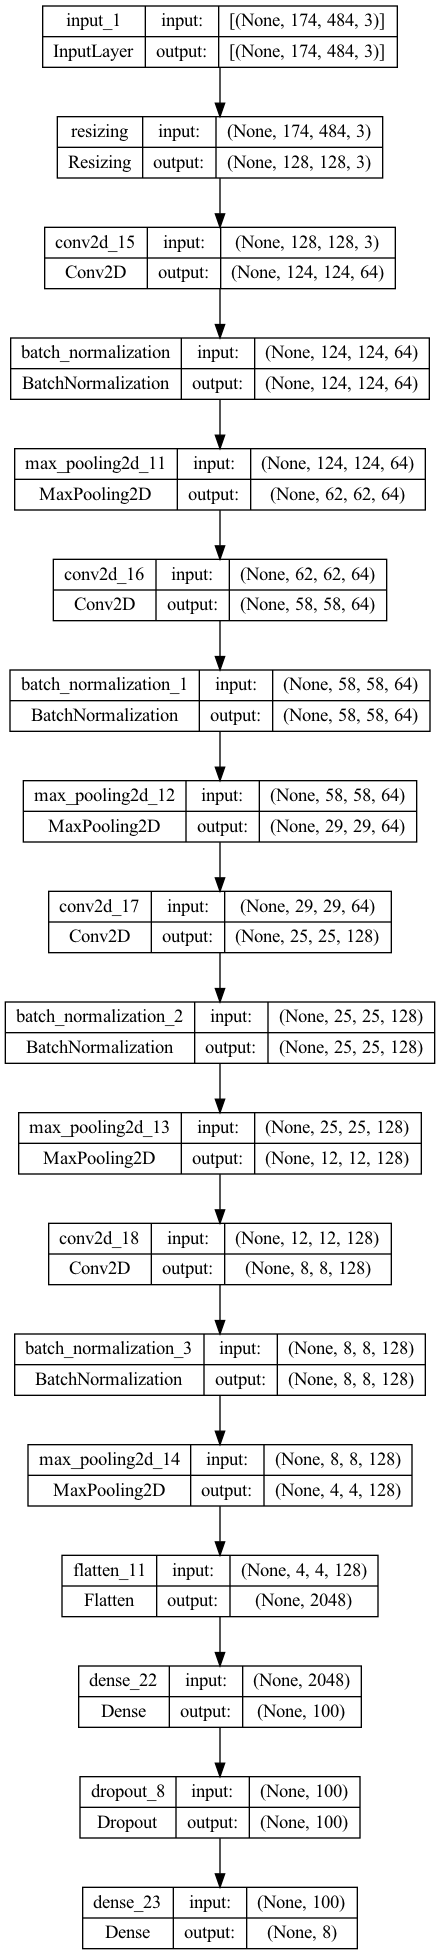

In [121]:
model = model2(
    width=484, height=174,
    depth=3, classes=len(genres))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
keras.utils.plot_model(model, show_shapes=True)

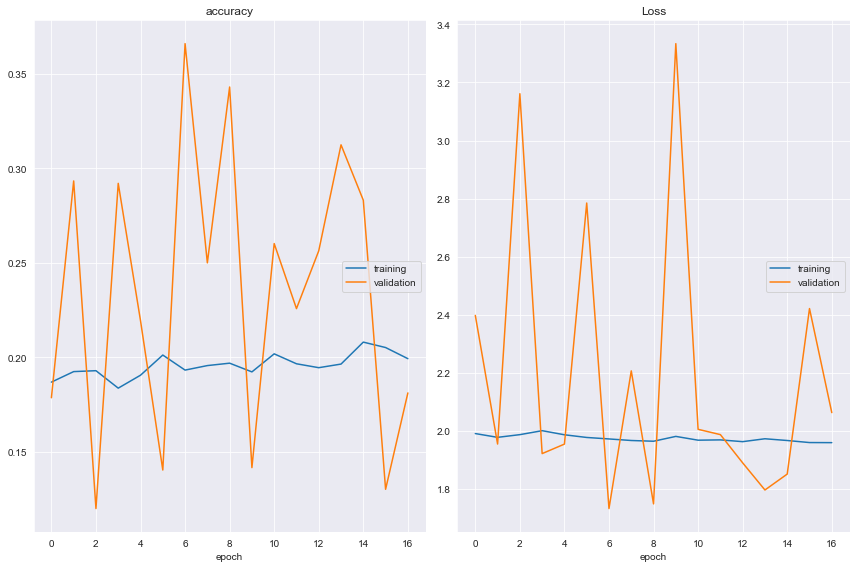

accuracy
	training         	 (min:    0.184, max:    0.208, cur:    0.199)
	validation       	 (min:    0.120, max:    0.366, cur:    0.181)
Loss
	training         	 (min:    1.960, max:    2.001, cur:    1.960)
	validation       	 (min:    1.733, max:    3.333, cur:    2.063)
99/99 [==============================] - 22s 220ms/step - loss: 1.9598 - accuracy: 0.1993 - val_loss: 2.0632 - val_accuracy: 0.1811


In [125]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

history = model.fit(training_data, training_labels, validation_data=(validation_data, validation_labels), epochs=50, batch_size=64, callbacks=[early_stop, PlotLossesKeras()])

In [129]:
model.save('mel_spectrogram_model')

INFO:tensorflow:Assets written to: mel_spectrogram_model/assets


INFO:tensorflow:Assets written to: mel_spectrogram_model/assets


In [130]:
model = keras.models.load_model("mel_spectrogram_model")


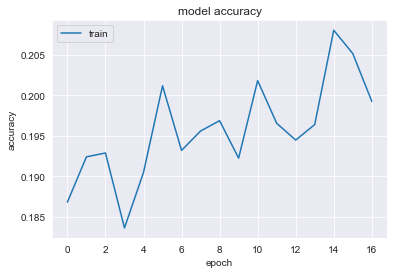

In [126]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [132]:
model.evaluate(testing_data, testing_labels)

 1/25 [>.............................] - ETA: 5s - loss: 1.5833 - accuracy: 0.3750

2022-06-17 14:12:36.483424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/25 [==============================] - 1s 37ms/step - loss: 1.7023 - accuracy: 0.3682


[1.7023465633392334, 0.3681528568267822]

In [131]:
image = tf.keras.preprocessing.image.load_img("dataset/Rock/6778.png")
image = img_to_array(image)
grr = [image]

image = tf.keras.preprocessing.image.load_img("dataset/Rock/61491.png")
image = img_to_array(image)
grr.append(image)

grr = np.array(grr, dtype="float") / 255.0

print(genres)

prediction = model.predict(grr)
display(Audio('data/tracks_wav/061491.wav', rate=22500))
pd.DataFrame(prediction, columns=list(genres.keys()))

{'Rock': 0, 'Electronic': 1, 'Folk': 2, 'Hip-Hop': 3, 'Pop': 4, 'Instrumental': 5, 'Experimental': 6, 'International': 7}
1/1 [==============================] - 0s 94ms/step


2022-06-17 14:12:22.490372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


,Rock,Electronic,Folk,Hip-Hop,Pop,Instrumental,Experimental,International
0,0.357118,0.093499,0.025122,0.050123,0.142723,0.023254,0.220322,0.087838
1,0.471762,0.043536,0.047294,0.021019,0.152515,0.029132,0.163145,0.071598
